In [0]:
try: 
  import tflearn #try to import tflearn
except ImportError:
    !pip3 install -q tflearn # install tflearn first
    import tflearn # then import it

In [0]:
import matplotlib.pyplot as plt                      # used for plotting images
import numpy as np                               # to do mathematical functions
import os, sys                              # to interact with filesystem 
import tensorflow as tf                               # tensorflow during training
from tflearn.activations import relu                        #rectified linear activation function if negative, would make them 0, and make positive numbers the same

#normalizes data normalize data siilar to bell curve: 
from tflearn.layers.normalization import batch_normalization as bn
from scipy.misc import imread, bytescale, imresize                                      # image manipulation functions
from tflearn.layers.core import input_data, dropout, fully_connected          #define layer shapes and network ; drop out certain values at random to distribute weights across all values; 
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.estimator import regression                               # trainer for the network
from tflearn.data_utils import to_categorical                          # turns scalar label into vector where appropriate class is value 1 and others 0 
from tflearn.data_augmentation import ImageAugmentation                       # makes new images from the ones we have by flipping them, rotating, etc.
from tensorflow.contrib.tensorboard.plugins import projector               #to visulaize the data space

In [0]:
def install_tensorboard_dep():             # starts tensor 
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def montage(x, plot_shape=(15, 15), return_grid=False, cmap='viridis'):
  '''
  Takes in a 4-D tensor, x, of shape [NxHxWxC] and puts all of the images
  together in a single matrix to show as one image. If return_grid is True, 
  it will not show the matrix, but return it to be used in some other 
  operations.
  '''
  
  count = 0
  if not return_grid:
    scale = [0, 255]
  else:
    scale = [0, 1]
  
  
  if len(x.shape) == 4 and x.shape[-1] == 3:
    num, m, n, c = x.shape
  else:
    num, m, n = x.shape
    c = 1
    
  num = int(np.ceil(np.sqrt(num)))
  grid = np.zeros([num*m, num*n, c])
  
  if c == 1:
    grid = grid[..., 0]
  
  for i in range(num):
    for j in range(num):
      if count < x.shape[0]:
        if c == 1:
          grid[i*m:i*m+m, j*n:j*n+n] = bytescale(x[count, ...], 
                                                 low=scale[0], high=scale[1])
        else:
          grid[i*m:i*m+m, j*n:j*n+n, :] = bytescale(x[count, ...],
                                                    low=scale[0], high=scale[1])
        count += 1 
        
  if return_grid:
    return grid
  else:
    fig = plt.figure(figsize=plot_shape)
    a1 = fig.add_subplot(111)
    a1.set_xticks(np.arange(-0.5, num*n, n))
    a1.set_yticks(np.arange(-0.5, num*m, m))
    a1.set_yticklabels([])
    a1.set_xticklabels([])
    a1.imshow(grid, cmap=cmap)
    plt.show()

In [0]:
def start_tensorboard():
  LOG_DIR = '/tmp/tflearn_logs'
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
def viz_embedding(tensor, images, labels, shape):
  
  tb_dir = '/tmp/tflearn_logs'
  sess = tf.Session()
  sess.run(tensor.initializer)
  summary_writer = tf.summary.FileWriter(tb_dir)
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = tensor.name
  embedding.metadata_path = os.path.join(tb_dir, 'metadata.tsv')
  embedding.sprite.image_path = os.path.join(tb_dir, 'flowers.png') 
  embedding.sprite.single_image_dim.extend(shape)
  projector.visualize_embeddings(summary_writer, config)
  saver = tf.train.Saver([tensor])
  saver.save(sess, os.path.join(tb_dir, 'flowers.ckpt'), 1)
  
  image_grid = montage(images, return_grid=True)
  plt.imsave(os.path.join(tb_dir, 'flowers.png'), image_grid)
  
  with open(os.path.join(tb_dir, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(labels):
      f.write("%d\t%d\n" % (index,label))
  f.close()

In [7]:
response = input('Do you want to train a network? (y/n) ') # ask user if they want to train or load 
#if input is yes, the network will train, if it is anything else, it will load a trained one in 
if response in ['Y', 'y', 'Yes', 'yes']:
  Train = True
else:
  Train = False

Do you want to train a network? (y/n) y


In [8]:
print(Train)

True


In [9]:
#import dataset loader from tflearn
import tflearn.datasets.oxflower17 as oxflower17

#load the data in as X and the labels in as Y
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(150,150))

100.0% 60276736 / 60270631


('Succesfully downloaded', '17flowers.tgz', 60270631, 'bytes.')
File Extracted
Starting to parse images...
Parsing Done!


In [10]:
print(X.shape, Y.shape) # print data and label shape
print(Y[:10,...]) # print first 10 label vectors 

(1360, 150, 150, 3) (1360, 17)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


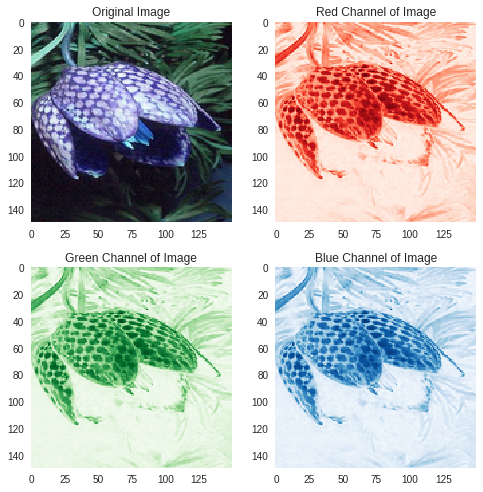

In [11]:
fig = plt.figure(figsize=(7,7))# create a figure of size 7x7
a1 = fig.add_subplot(221) # add the first of four subplots in the figure
a2 = fig.add_subplot(222) # add second
a3 = fig.add_subplot(223)
a4 = fig.add_subplot(224)

x_show = X[0,:,:,::-1] # get the first image from the dataset
a1.imshow(bytescale(x_show)) # show original image
a2.imshow(x_show[...,0], cmap='Reds') # show first color channel
a3.imshow(x_show[...,0], cmap='Greens') # show green color channel
a4.imshow(x_show[...,0], cmap='Blues') # show third color channel

#remove grid and tick lines
a1.grid(False)
a2.grid(False)
a3.grid(False)
a4.grid(False)

#name each subplot
a1.set_title('Original Image')
a2.set_title('Red Channel of Image')
a3.set_title('Green Channel of Image')
a4.set_title('Blue Channel of Image')


plt.tight_layout() # helps organize figure if there are many subjects

In [12]:
montage(X[..., ::-1], (18, 18))

In [0]:
weight_filter = np.random.randn(5, 5, 3)     #make random weights
random_img = X[100, ...]      # take 100 images from data set
output_feature_map = np.zeros([random_img.shape[0], random_img.shape[1]]) #create empty feature map

In [0]:
for i in range(5, random_img.shape[0]-5): #loop throug rows
  for j in range(random_img.shape[0]-5): #loop throug columns
    output_feature_map[i, j] = np.sum(weight_filter * random_img[i:i+5, j:j+5, :]) # weighted sum


In [15]:
print(np.amax(output_feature_map), np.amin(output_feature_map))

7.696023987167206 -1.3812474612037156


In [0]:
output_feature_map = bytescale(output_feature_map)

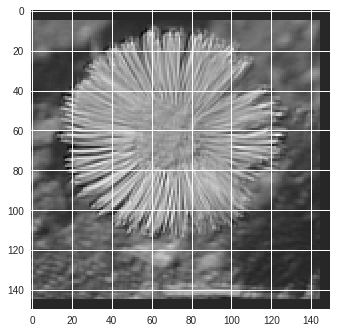

In [17]:
plt.imshow(output_feature_map, cmap = 'gray')

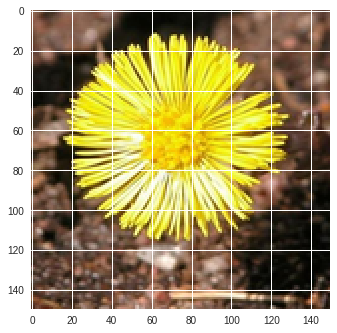

In [18]:
plt.imshow(random_img)

In [0]:
#make negative activation values 0 and keep positive ones
output_feature_map = np.int32(output_feature_map > 0) * output_feature_map

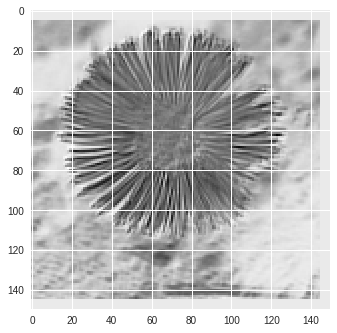

In [20]:
plt.imshow(np.float32(output_feature_map))

(array([2515748., 1970901., 1271388., 1831295., 1176952., 1750327.,
        1154911., 1727703., 1163294., 1716089., 1713582., 1138158.,
        1696632., 1133004., 1683842., 1110720., 1658613., 1105884.,
        1650764., 1078074., 1597916., 1584430., 1039727., 1540190.,
        1009702., 1501586.,  994556., 1476760.,  970707., 1433303.,
        1406113.,  922733., 1357350.,  888378., 1310056.,  866204.,
        1277732.,  836260., 1235241.,  808561., 1190542., 1170592.,
         768601., 1128441.,  732964., 1074155.,  701244., 1024838.,
         669354.,  974687.,  949644.,  622067.,  908548.,  593716.,
         877349.,  573999.,  850167.,  562083.,  820562.,  536725.,
         791542.,  778159.,  510491.,  757984.,  499769.,  741845.,
         489462.,  728432.,  485462.,  710574.,  702556.,  461258.,
         679423.,  445237.,  659305.,  431860.,  639862.,  422443.,
         631124.,  409200.,  620001.,  608083.,  390823.,  573901.,
         386288.,  544991.,  357308.,  525271., 

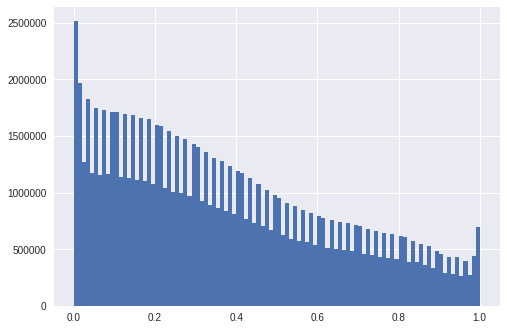

In [21]:
plt.hist(X.flatten(), bins = 100)

In [0]:
#preprocess our data for training by subtracting mean and dividing by standard deviation
X-= np.mean(X, 0) # center each pixel value around 0 
X /= np.std(X, 0) #squash each pixel between 1 and -1

(array([8.500000e+02, 5.138000e+03, 1.051000e+04, 2.470100e+04,
        4.701600e+04, 7.110500e+04, 9.616600e+04, 1.266050e+05,
        1.608420e+05, 2.050810e+05, 2.684040e+05, 3.692080e+05,
        5.376470e+05, 7.226540e+05, 9.138810e+05, 1.098719e+06,
        1.186559e+06, 1.318426e+06, 1.722881e+06, 2.431511e+06,
        3.097666e+06, 2.965100e+06, 2.831179e+06, 2.743261e+06,
        2.668500e+06, 2.606102e+06, 2.552031e+06, 2.489256e+06,
        2.438237e+06, 2.380064e+06, 2.328387e+06, 2.275069e+06,
        2.218941e+06, 2.155295e+06, 2.095425e+06, 2.036056e+06,
        1.981002e+06, 1.921050e+06, 1.863735e+06, 1.814714e+06,
        1.759519e+06, 1.701728e+06, 1.643046e+06, 1.590108e+06,
        1.539029e+06, 1.487765e+06, 1.440067e+06, 1.396609e+06,
        1.358059e+06, 1.313775e+06, 1.274262e+06, 1.231581e+06,
        1.187706e+06, 1.147281e+06, 1.104260e+06, 1.068386e+06,
        1.030881e+06, 9.920010e+05, 9.207110e+05, 8.449190e+05,
        7.750930e+05, 6.923470e+05, 6.37

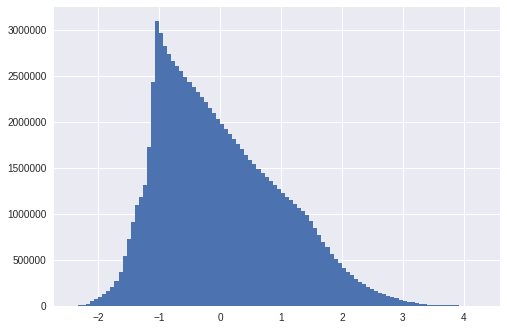

In [23]:
plt.hist(X.flatten(), bins = 100)

In [0]:
#print

In [0]:
tf.reset_default_graph() # reset tensorflow graph

In [0]:
#augment images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=33.) # randomly rotatte images up to 33 degrees
img_aug.add_random_crop((150,150), padding=15) # crop image down to 120 by 120

In [0]:
#create a layer to view data space in tensorboard
emb = tf.Variable(X[::10, ...], name= 'input_flower_images')

In [0]:
#tflearn documentation --- http://tflearn.org/

#create input layer that takes in images and augments them as well
in_layer = input_data(shape=[None, 150, 150, 3], data_augmentation=img_aug)

#have 64 7x7 filters slide over the input images
conv1 = conv_2d(in_layer, 64, 7, activation='linear', name='c1') 

#normalize conv1 layer feature maps
batch_norm1 = bn(conv1, name='bn1')

#perform relu activation function
relu1 = relu(batch_norm1)

#max pooling
pool1 = max_pool_2d(relu1, 3, 2)

#128 3x3 filters
conv2 = conv_2d(pool1, 128, 3, activation='linear', name='c2')

#normalize conv1 layer feature maps
batch_norm2 = bn(conv2, name='bn2')

#perform relu activation function
relu2 = relu(batch_norm2)

#max pooling
pool2 = max_pool_2d(relu2, 3, 2)

#conv3 layer 256 3x3 filters
conv3 = conv_2d(pool2, 256, 3, activation='linear', name='c3')

#normalize conv3 layer feature maps
batch_norm3 = bn(conv3, name='bn3')

#perform relu activation function c3 heat maps --- num images x 37 x 37 x 256
relu3 = relu(batch_norm3)

#take the average of each of the 256 feature maps --- num_images x 1 x 1 x 256
gap = global_avg_pool(relu3)

#17 values, input-gap, softmax = between 0-1, but add up to 1 (node values)
out_layer = fully_connected(gap, 17, activation='softmax', name='fc')



In [0]:
#describe how to optimize the network's weights
network = regression(out_layer, optimizer='adam',
                    loss='categorical_crossentropy', learning_rate=.001)                      
  

In [0]:
#build the netork based on the desciption above
model = tflearn.DNN(network, tensorboard_verbose=2)

In [36]:
#name for tensorboard
tensorboard_name = 'flowers_cnn'
viz_embedding(emb, X[::10, ...], np.argmax(Y[::10, ...], 1), [150, 150, 3])

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImageAugmentation' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [37]:
#start tensorboard
install_tensorboard_dep()
start_tensorboard()

--2018-10-15 18:13:14--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.4.75.11, 52.44.92.122, 54.164.206.44, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.4.75.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.48MB/s    in 1.5s    

2018-10-15 18:13:16 (3.48 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [0]:
if Train:
  
  model.fit(X,
            Y,
            n_epoch=50,
            shuffle=True,
            validation_set=0.1, 
            show_metric=True,
            batch_size = 50,
            run_id = 'OxfordFlowers_CNN')
  model.save('flowers_CNN')

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
def load_layer(layer_name, data):
  layer = sess.run(layer_name, {in_layer:data[None, ...]})
  print(layer.shape)
  return layer

In [0]:
def view_feature_map(layer):
  n, h, w, c = layer.shape #get layers shape
  layer = layer.transpose((0, 3, 1, 2)).reshape([n*c, h, w])
  montage(layer, cmap='gray')

In [0]:
# choose 1 random number between 0 and the number of examples in the dataset
random_index = np.random.randint(0, X.shape[0], 1)[0]

# take out the image at that spot to use 
new_img = X[random_index, ...]

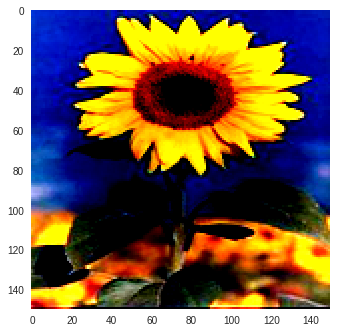

In [73]:

# view the original image
img_show = bytescale(new_img, 0, 1) # make values in new_img go between 0 and 1 to show it in matplotlib
plt.imshow(img_show)  # tell it what to show
plt.grid(False)  # get rid of the gridlines since this is not a graph
plt.show()  # show the image

(1, 150, 150, 64)


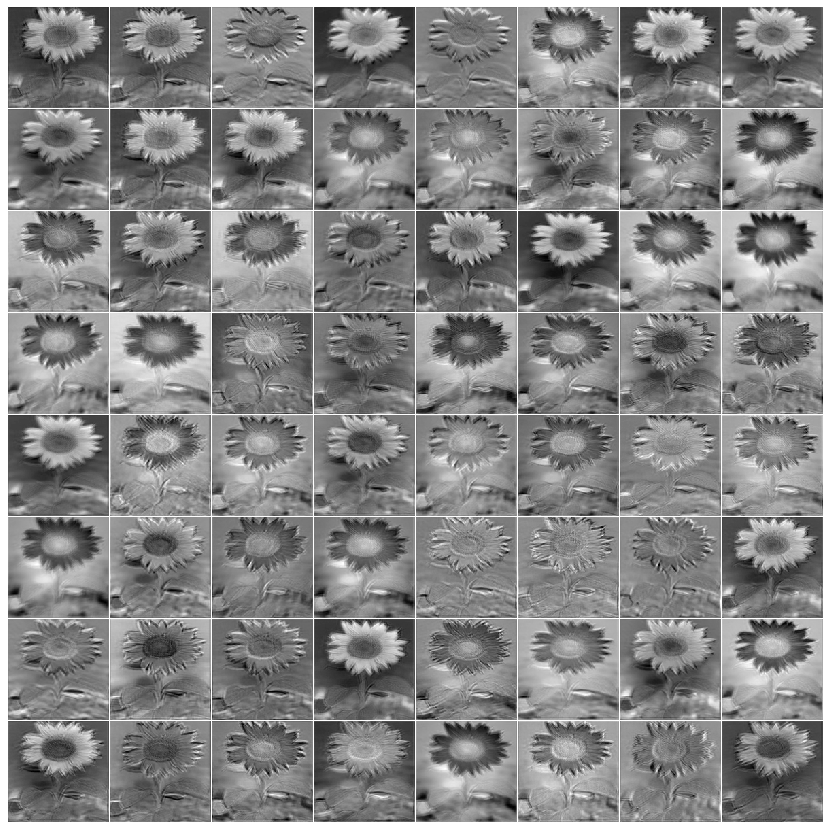

In [74]:
# view the first conv layer's feature maps --- 64 different views of the image to help decide what it is
view_feature_map(load_layer(conv1, new_img))

The first convolution layer is looking at different edges and features of the original image.


(1, 150, 150, 64)


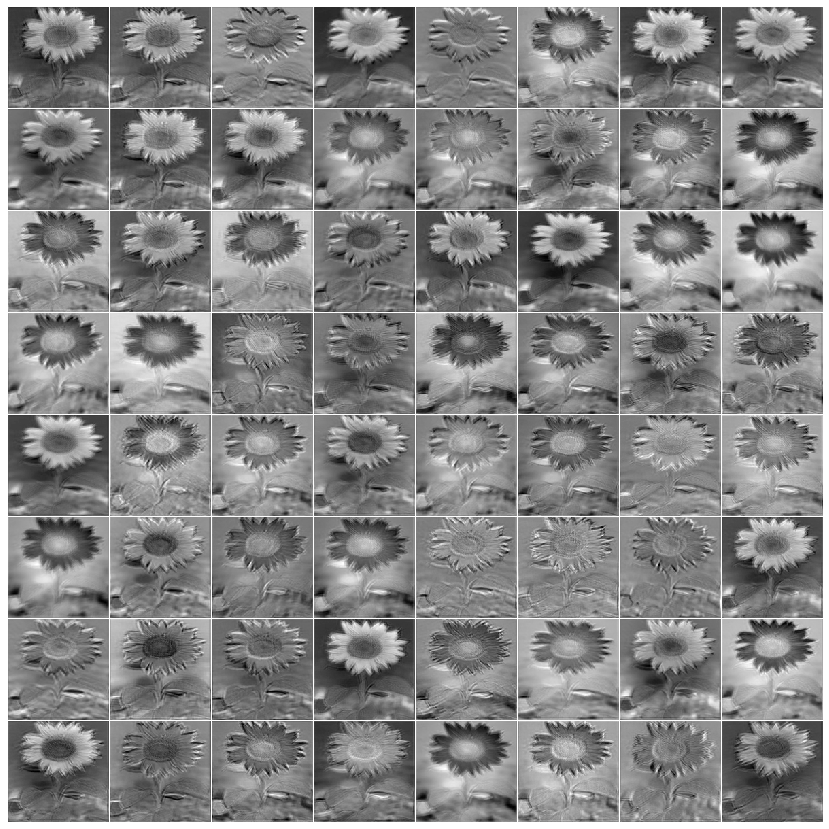

In [76]:
#view results of the normalization layer
view_feature_map(load_layer(batch_norm1, new_img))

Batch normalization normalizes the images that were previously convoluted. Many of the images now have smoother contrast edges, which eases the processes that the network must complete. When the edge is too sharp, the network may misinterpret the edges.


(1, 150, 150, 64)


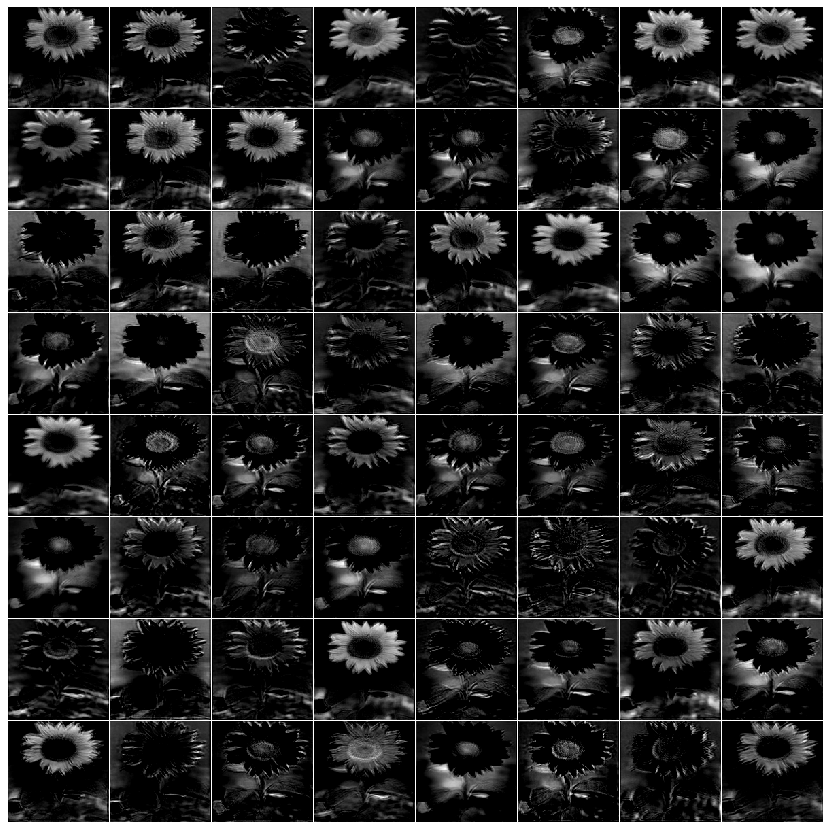

In [77]:
view_feature_map(load_layer(relu1, new_img))

The first reLu layer displays a more contrasted image of the convolution. The relu function is designed to re-organize the outputs into a more smooth input to feed to the next layer.

(1, 75, 75, 64)


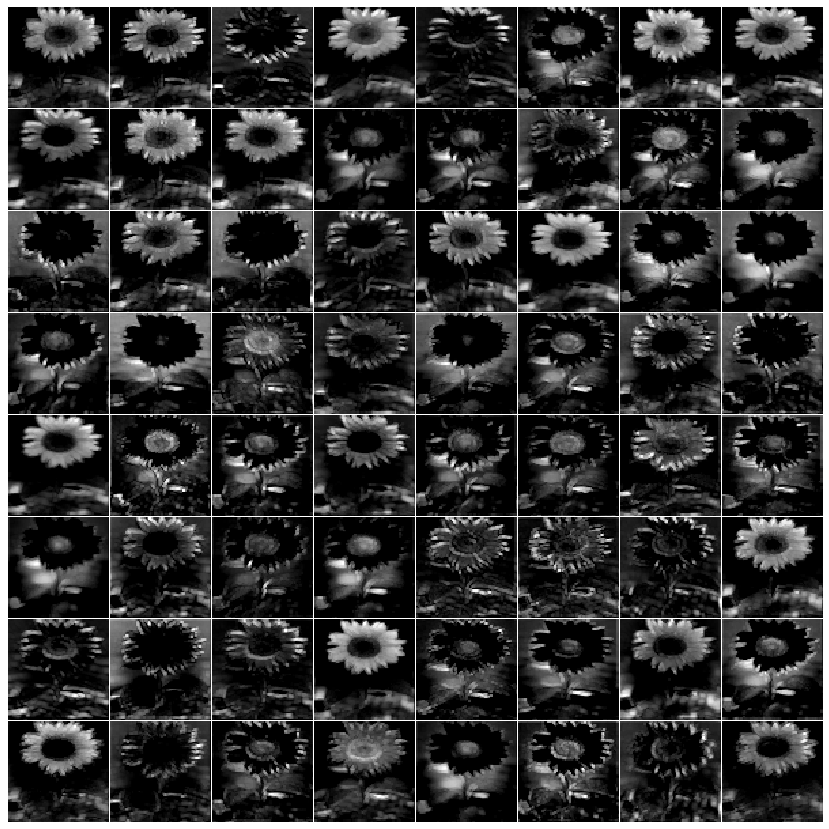

In [78]:
view_feature_map(load_layer(pool1, new_img))

The feature layer of the first pooling layer displays a much sharper image, likely due to the pooling effect of taking a specific set of values rather than the entire set, leaving a more uniform value.

(1, 75, 75, 128)


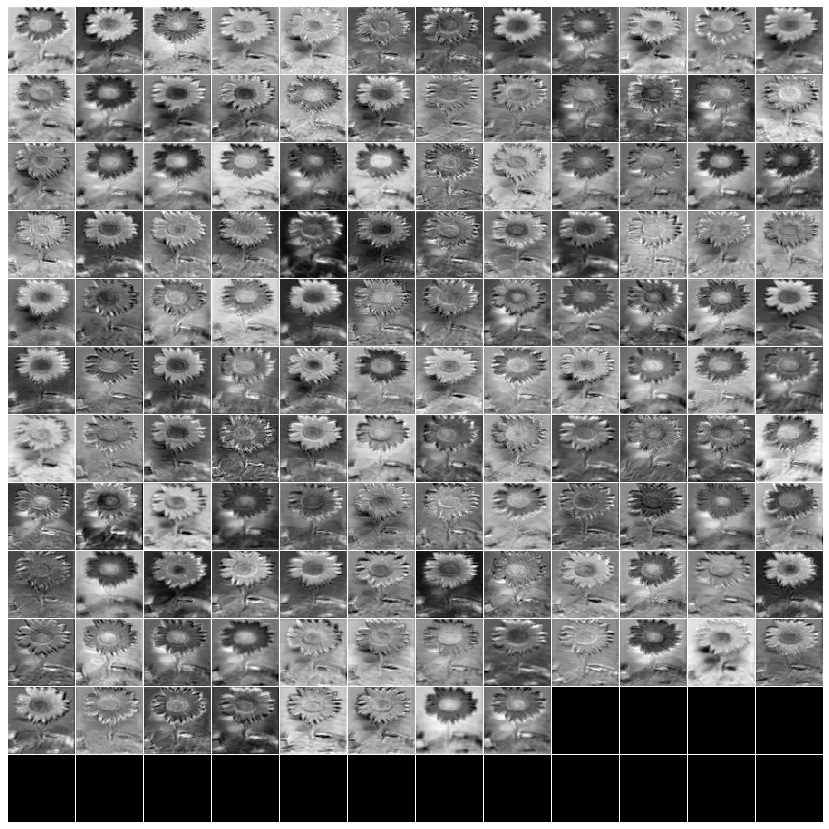

In [79]:
view_feature_map(load_layer(conv2, new_img))

Once again, the convolution takes the images of the last pooling layer and convolutes the images again, looking for the features in order to find specific values within the image.

(1, 75, 75, 128)


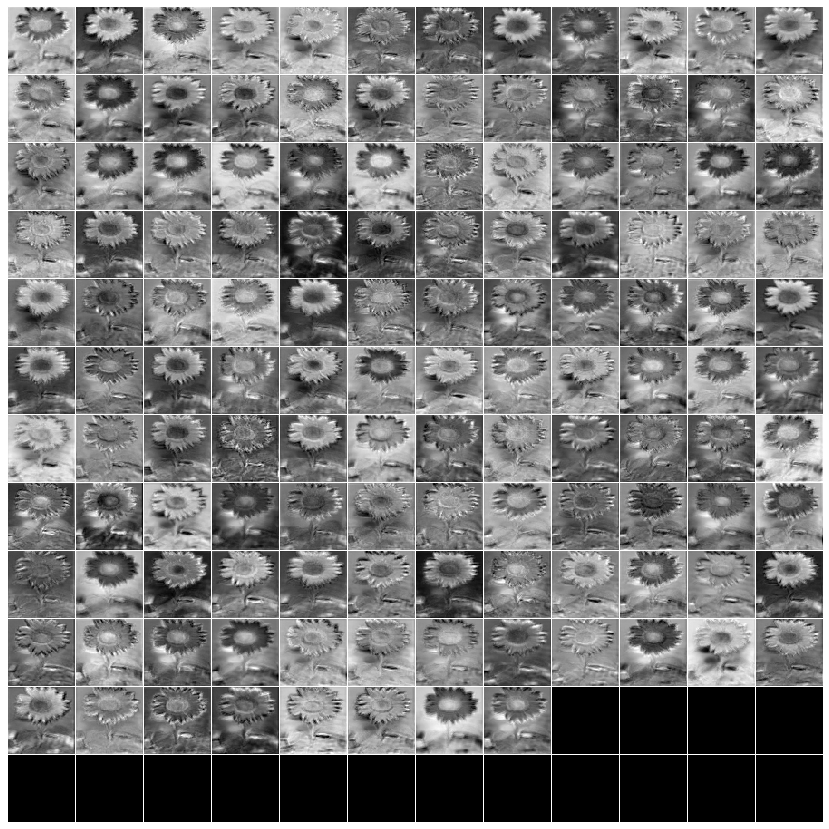

In [80]:
view_feature_map(load_layer(batch_norm2, new_img))

The normalization layer interprets the past input by making the image easier to analyze for future layers by attempting to eliminate biases that may occur, similar to the previous layer.

(1, 75, 75, 128)


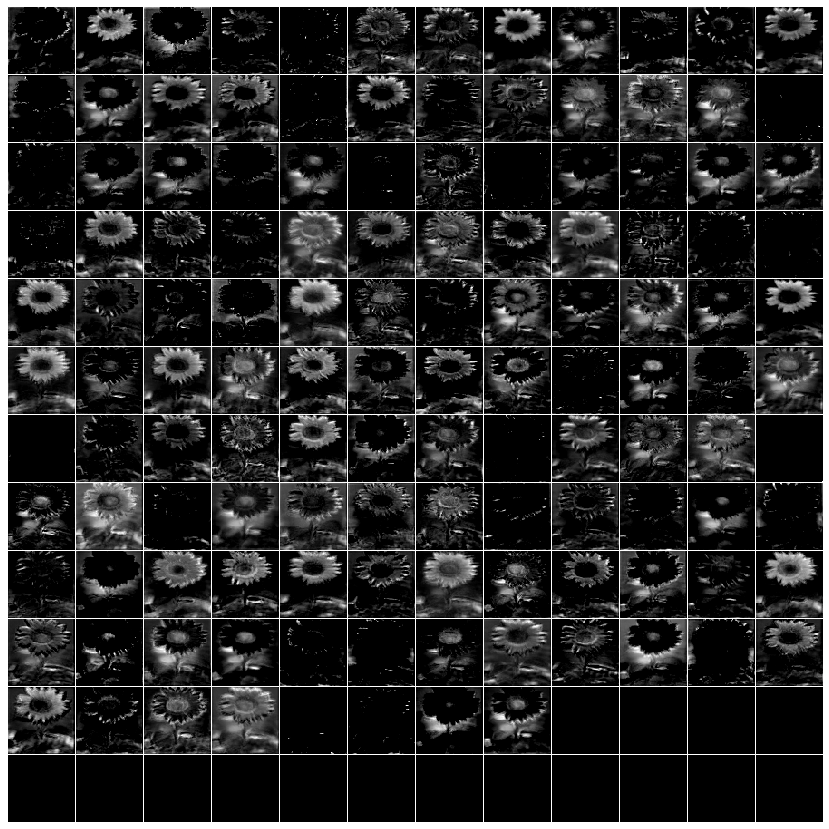

In [81]:
view_feature_map(load_layer(relu2, new_img))

The reLU layer acted upon the inputs to create a more easy to analyze image. The ReLU layer is intended to get rid of negative values, and keep positive values, which is represented.

(1, 38, 38, 128)


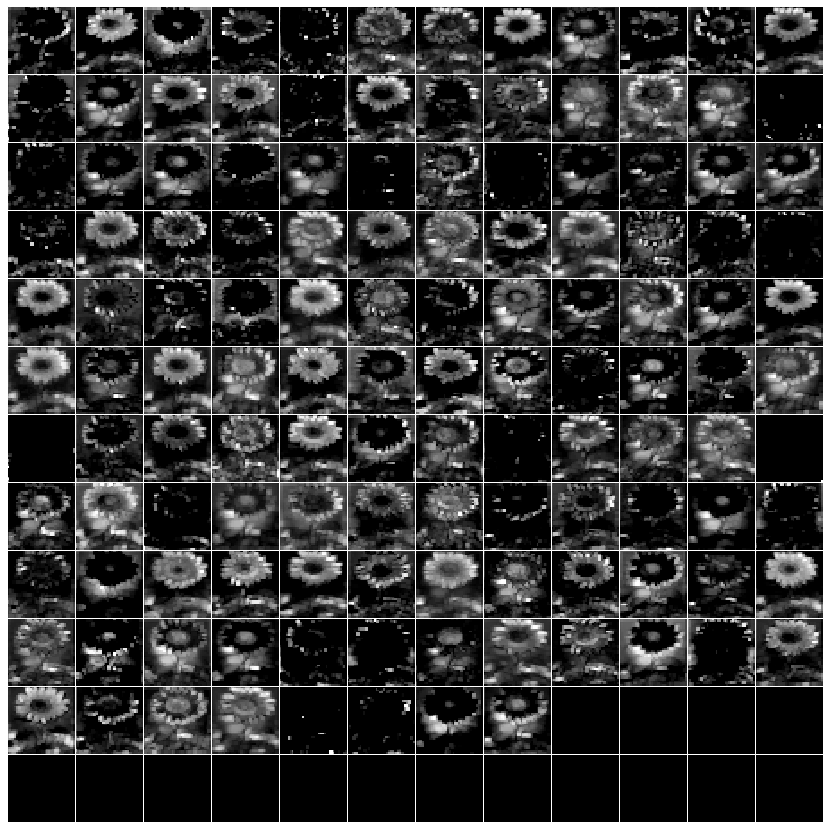

In [82]:
view_feature_map(load_layer(pool2, new_img))

Similar to the last pooling layer, this pooling layer simplifies the previous input in order to analyze easily.

(1, 38, 38, 256)


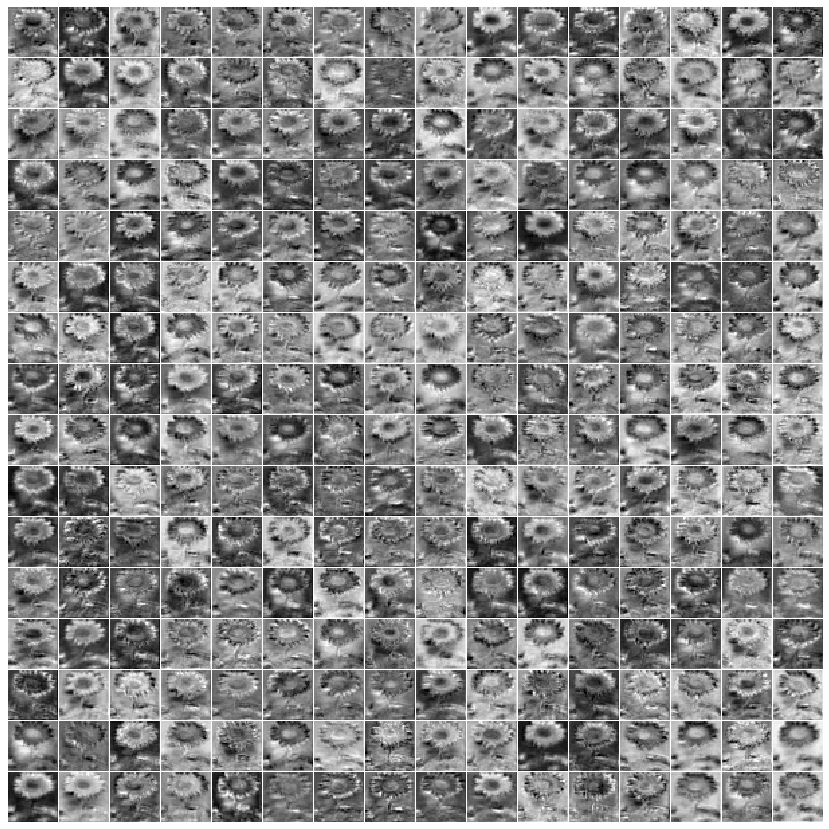

In [83]:
view_feature_map(load_layer(conv3, new_img))

Once again, the layer convolutes the inputs by looking at and assigning weights to the data values of the image by examining the filters and features of the image.

(1, 38, 38, 256)


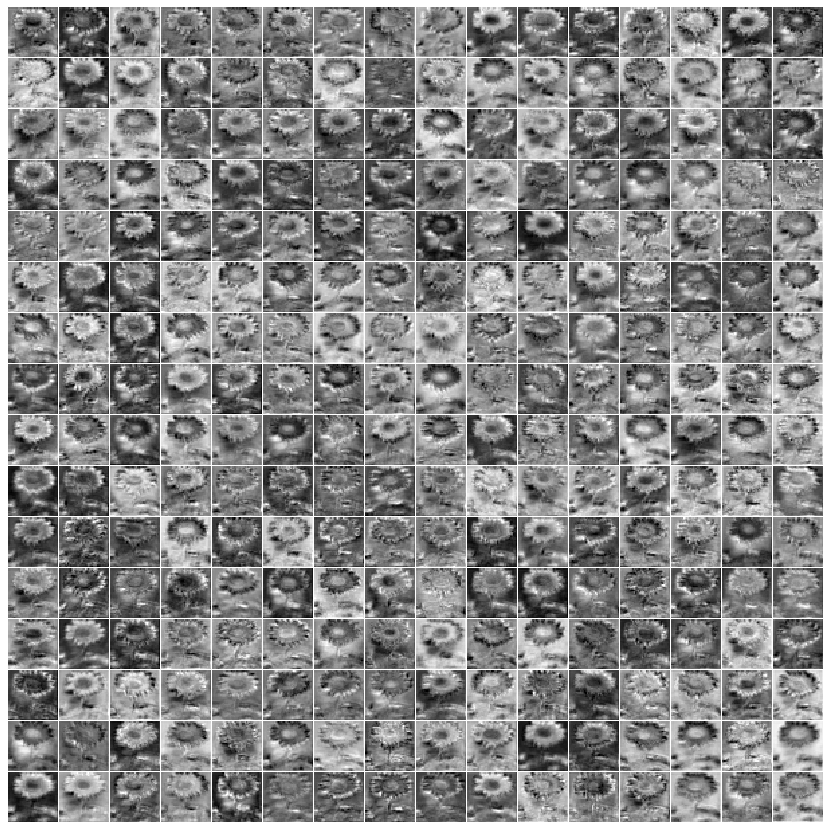

In [84]:
view_feature_map(load_layer(batch_norm3, new_img))

This layer simplified the previous images in order to customize the image into a definitive answer to the issue.

(1, 38, 38, 256)


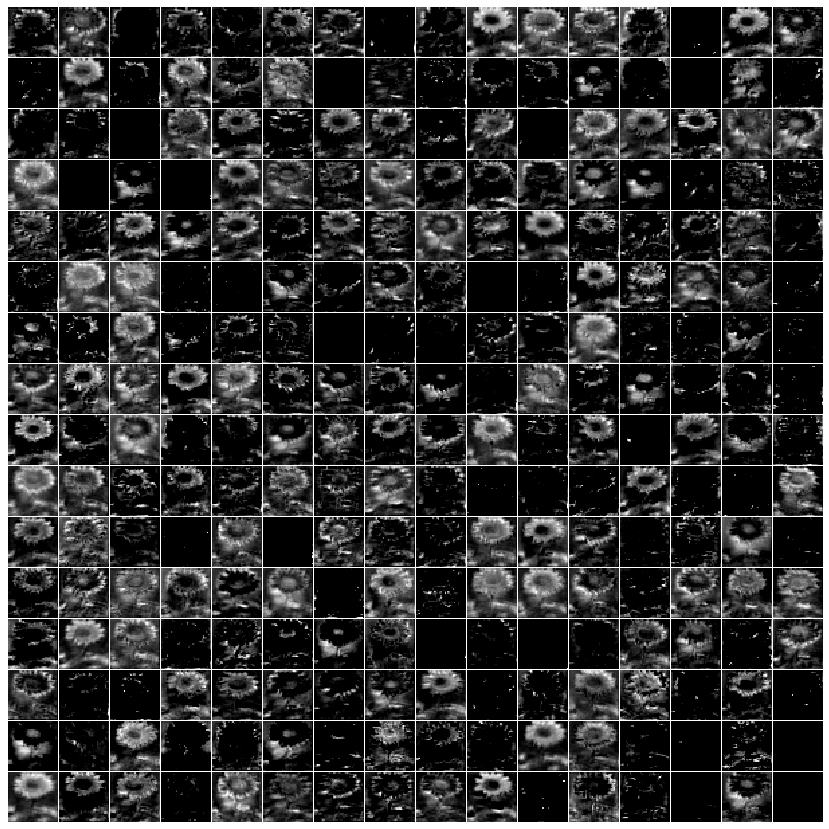

In [85]:
view_feature_map(load_layer(relu3, new_img))

Once again, the ReLU function created a set of data values that lacked negatives, leading to an output that has a clearly visible answer to the issue, a more clear demonstration of how the convolutional neural network searched for something.
